In [1]:
import json
import os
import pandas as pd
import ast
import numpy as np

# 从准确率>0.6的类别中，准确率相同的类别各选一类
最终选出index_list =  ['110', '174', '230', '241', '249', '254', '369', '408', '423', '460', '492', '534', '552', '723', '725', '733', '741', '751', '848', '948']

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os

save_path = './data_stage2/class_acc_vit_b_16.json'
# save_path = './data_stage3/class_acc_vgg16.json'
acc = json.load(open(save_path))

# 提取键和值
values = list(acc.values())

# 创建图形并设置大小
plt.figure(figsize=(10, 4))

# 绘制柱状图
plt.bar(range(len(values)), values, color='lightblue', width=1)
plt.title('Accuracy for each category')
plt.ylabel('Accuracy')
plt.ylim(0, 1.05)  # 设置y轴范围以更好地显示差异
plt.xticks([])  # 隐藏x轴
# plt.grid(axis='y', linestyle='--', linewidth=0.5)  # 仅显示y轴的网格线

# 显示图形
plt.show()

In [ ]:
import random

# 过滤出值大于 0.6 的唯一值
unique_acc_values = {v for v in acc.values() if v >= 0}

# 根据唯一值分组
acc_groups = {value: [] for value in unique_acc_values}
for category, accuracy in acc.items():
    if accuracy >= 0:
        acc_groups[accuracy].append(category)

# 从每个分组中随机抽取一个类别
selected_categories = {random.choice(categories): accuracy for accuracy, categories in acc_groups.items()}

print(selected_categories)
print(len(selected_categories))


In [ ]:
acc

In [ ]:
# 输出selected_categories中每个类别的label号
imagenet_class_index_path='data/imagenet_class_index.json'
imagenet_class_index = json.load(open(imagenet_class_index_path))
lndexs = []
index2acc = {}
for id, (code, name) in imagenet_class_index.items():
    if code in selected_categories:
        lndexs.append(id)
        index2acc[id] = selected_categories[code]
# print(len(lndexs))
# 将index2acc按照值排序
index2acc = sorted(index2acc.items(), key=lambda x: x[1])
print(index2acc)

In [ ]:
def select_class(ranks, save_path, imagenet_class_index_path='data/imagenet_class_index.json', chinese_class_index_path = 'data/chinese_class_index.json'):
    ''' 筛选出指定排名的类别
    
    Args:
    - ranks: list, 指定的排名
    - class_index_dict: dict, 类别索引
    - chinese_class_index_dict: dict, 中文类别索引
    - acc: dict, 所有类别准确率
    '''
    with open(imagenet_class_index_path) as f:
        class_index_dict = json.load(f)

    with open(chinese_class_index_path) as f:
        chinese_class_index_dict = json.load(f)
    
    acc = json.load(open(save_path))
    
    sorted_acc = sorted(acc.items(), key=lambda x: x[1], reverse=True)
    selected_items = {k: v for i, (k, v) in enumerate(sorted_acc) if i+1 in ranks}
    result = {}
    for rank, (class_code, accuracy) in zip(ranks, selected_items.items()):
        for id, (code, name) in class_index_dict.items():
            if code == class_code:
                chinese_name = chinese_class_index_dict[str(id)]
                corect_num = int(accuracy * 50)
                result[id] = [class_code, name, chinese_name, accuracy, corect_num, rank]
                break
    return result

In [ ]:
save_path = 'data_stage2/class_acc_vit_b_16.json'
result = select_class([1, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], save_path)
print(result)

# 对选出来的类别进行处理

In [1]:
import numpy as np
import json
import pandas as pd
import os

acc_path = './data_stage2/class_acc_vit_b_16.json'
imagenet_class_index_path='data/imagenet_class_index.json'
chinese_class_index_path = 'data/chinese_class_index.json'

with open(imagenet_class_index_path) as f:
    class_index_dict = json.load(f)

with open(chinese_class_index_path) as f:
    chinese_class_index_dict = json.load(f)
    
with open(acc_path) as f:
    acc = json.load(f)

id_list = ['110', '174', '230', '241', '249', '254', '369', '408', '423', '460', '492', '534', '552', '723', '725', '733', '741', '751', '848', '948']

In [3]:
# 将id_list中的类别的id、准确率、按照准确率的排名、中文名、英文名组合成一个pandas.DataFrame
data = []

for class_id in id_list:
    if class_id in class_index_dict:
        imagenet_id, english_name = class_index_dict[class_id]
        # chinese_name = chinese_class_index_dict.get(class_id, '未知')
        accuracy = acc.get(imagenet_id, 0.0)
        data.append([class_id, accuracy, english_name])

# 创建 DataFrame
df = pd.DataFrame(data, columns=['Label', 'Accuracy', 'Name'])

# 按照准确率排序
df = df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# 添加排名列
df['Rank'] = df.index + 1
df['Number'] = (df['Accuracy'] * 50).astype(int)

df

,Label,Accuracy,Name,Rank,Number
0,254,1.00,pug,1,50
1,723,0.98,pinwheel,2,49
2,948,0.96,Granny_Smith,3,48
3,174,0.94,Norwegian_elkhound,4,47
4,110,0.92,flatworm,5,46
5,741,0.90,prayer_rug,6,45
6,492,0.88,chest,7,44
7,552,0.86,feather_boa,8,43
8,423,0.84,barber_chair,9,42
9,230,0.82,Shetland_sheepdog,10,41


In [4]:
df.to_excel('data_stage3/vit_b_16_top_20.xlsx', index=False)

# 对单步法结果文件进行处理

## 结果文件处理

In [2]:
data = pd.read_excel('./data_stage3/classified_single_attack/classified_single_attack_1108.xlsx')
data.head()

,index,model,algo,mask_mode,parameter,eta,pixel_attacked,attack_ratio_per_channel,l1_norm,l2_norm,success_rate,original_loss,attack_loss,pred_loss,picture_all,picture_attacked,run_time
0,110,vit_b_16,fgsm,positive,NaN,0.01,75167,"[0.4994, 0.5023, 0.4964]",63.7967,0.021287,0.543478,0.106,1.321034,0.743967,46,24,1.219
1,110,vit_b_16,fgsm,negative,NaN,0.01,75360,"[0.5006, 0.4977, 0.5036]",63.8044,0.022033,0.521739,0.106,1.316953,0.744044,46,23,1.200
2,110,vit_b_16,fgsm,all,NaN,0.01,150528,"[1.0, 1.0, 1.0]",127.6011,0.043320,0.760870,0.106,2.346717,1.382011,46,34,1.278
3,110,vit_b_16,fgsm,topr,0.01,0.01,1505,"[0.0095, 0.0138, 0.0067]",19.8795,0.025637,0.086957,0.106,0.260314,0.304795,46,4,1.391
4,110,vit_b_16,fgsm,topr,0.11,0.01,16558,"[0.1072, 0.1377, 0.0851]",68.3997,0.039738,0.413043,0.106,0.929253,0.789997,46,19,1.306


In [3]:
def mean_of_lists(series):
    # 将每个元素转换为 NumPy 数组，然后计算均值
    arrays = np.array(series.tolist(), dtype=float)
    return np.mean(arrays, axis=0).tolist()

def calculate_eta_reverse(row):
    if row['mask_mode'] in ('cam_lowr', 'lowr', 'seed_randomr_lowr', 'channel_lowr','lrp_lowr'):
        return 1 - row['parameter']
    else:
        return row['parameter']

def l1_norm(series):
    return series.abs().sum()

def l2_norm(series):
    return np.sqrt((series ** 2).sum())

def merge_batch_onestep(data): 
    '''将多个batch的数据合并''' 
    data['parameter'] = data['parameter'].fillna(-1)
    data['attack_ratio_per_channel'] = data['attack_ratio_per_channel'].apply(ast.literal_eval)
    li = ['index', 'model', 'algo', 'mask_mode', 'parameter', 'eta']
    data_grouped = data.groupby(li).agg({
        'pixel_attacked': lambda x: int(x.mean()),
        'attack_ratio_per_channel': mean_of_lists,
        'l1_norm': l1_norm,
        'l2_norm': l2_norm,
        'original_loss'	: 'mean',
        'attack_loss': 'mean',
        'pred_loss': 'mean',
        'success_rate': lambda x: round(x.mean(), 4),
        'run_time': 'sum',
    }).reset_index()
    data_grouped[['R', 'G', 'B']] = pd.DataFrame(data_grouped['attack_ratio_per_channel'].tolist(), index=data_grouped.index)
    data_grouped['parameter0'] = data_grouped.apply(calculate_eta_reverse, axis=1)
    data_grouped.drop('attack_ratio_per_channel', axis=1, inplace=True)
    return data_grouped

In [4]:
data_grouped = merge_batch_onestep(data)

In [5]:
data_grouped.head()

,index,model,algo,mask_mode,parameter,eta,pixel_attacked,l1_norm,l2_norm,original_loss,attack_loss,pred_loss,success_rate,run_time,R,G,B,parameter0
0,110,vit_b_16,fgsm,all,-1.00,0.01,150528,127.6011,0.043320,0.106,2.346717,1.382011,0.7609,1.278,1.00,1.00,1.00,-1.00
1,110,vit_b_16,fgsm,cam_lowr,0.01,0.01,1503,4.5637,0.005764,0.106,0.116615,0.151637,0.0000,2.260,0.01,0.01,0.01,0.99
2,110,vit_b_16,fgsm,cam_lowr,0.11,0.01,16557,20.6653,0.013208,0.106,0.225279,0.312653,0.0870,2.162,0.11,0.11,0.11,0.89
3,110,vit_b_16,fgsm,cam_lowr,0.21,0.01,31608,32.1540,0.016109,0.106,0.358356,0.427540,0.1522,2.259,0.21,0.21,0.21,0.79
4,110,vit_b_16,fgsm,cam_lowr,0.31,0.01,46662,42.1077,0.018371,0.106,0.514063,0.527077,0.2609,2.314,0.31,0.31,0.31,0.69


In [19]:
data_rack = pd.read_excel('data_stage3/vit_b_16_top_20.xlsx')
data_all = pd.merge(data_grouped, data_rack, left_on='index', right_on='Label', how='left')
data_all.drop('Label', axis=1, inplace=True)
data_all.head()

,index,model,algo,mask_mode,parameter,eta,pixel_attacked,l1_norm,l2_norm,original_loss,...,success_rate,run_time,R,G,B,parameter0,Accuracy,Name,Rank,Number
0,110,vit_b_16,fgsm,all,-1.00,0.01,150528,127.6011,0.043320,0.106,...,0.7609,1.278,1.00,1.00,1.00,-1.00,0.92,flatworm,5,46
1,110,vit_b_16,fgsm,cam_lowr,0.01,0.01,1503,4.5637,0.005764,0.106,...,0.0000,2.260,0.01,0.01,0.01,0.99,0.92,flatworm,5,46
2,110,vit_b_16,fgsm,cam_lowr,0.11,0.01,16557,20.6653,0.013208,0.106,...,0.0870,2.162,0.11,0.11,0.11,0.89,0.92,flatworm,5,46
3,110,vit_b_16,fgsm,cam_lowr,0.21,0.01,31608,32.1540,0.016109,0.106,...,0.1522,2.259,0.21,0.21,0.21,0.79,0.92,flatworm,5,46
4,110,vit_b_16,fgsm,cam_lowr,0.31,0.01,46662,42.1077,0.018371,0.106,...,0.2609,2.314,0.31,0.31,0.31,0.69,0.92,flatworm,5,46


## 画图

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_success_rate_vs_r(data, eta, algo, var, label_list, **kwargs):
    '''
    绘制不同类别的样本，各个标签（label）与参数（parameter）的关系图。
    每个子图表示一个模型和一个标签的关系，图例表示不同的 mask_mode。

    Args:
        data (pd.DataFrame): 数据集
        eta (float): eta值
        algo (str): 攻击算法
        var: x轴参数
        label_list (list): 需要绘制的标签列表，例如 ['success_rate', 'l1_norm', 'l2_norm', 'attack_loss', 'pixel_attacked']
    '''
    output_path = kwargs.get('output_path', None)
    save_name = kwargs.get('save_name', None)
    locate = kwargs.get('locate', 'buttle')  # 默认图例位置为底部
    
    df_filtered = data[(round(data['eta'],2) == eta) & (data['algo'] == algo)].copy()
    df_filtered = df_filtered.reset_index(drop=True)
    
    # 获取唯一的模型和mask_mode
    model_list = kwargs.get('model_list', ['vit_b_16'])
    mask_mode_list = kwargs.get('mask_mode_list', df_filtered['mask_mode'].unique())
    id_list = kwargs.get('id_list', ['110', '174', '230', '241', '249', '254', '369', '408', '423', '460', '492', '534', '552', '723', '725', '733', '741', '751', '848', '948'])
    
    picture_num = len(id_list) * len(label_list)
    
    ncols = kwargs.get('ncols', int(np.ceil(np.sqrt(picture_num))))
    nrows = kwargs.get('nrows', int(np.ceil(picture_num / ncols)))

    palette = sns.color_palette("tab10", n_colors=len(mask_mode_list))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4), squeeze=False)
    axes = axes.flatten()

    for i, id in enumerate(id_list):
        df_id = df_filtered[df_filtered['index'] == int(id)]
        for j, label in enumerate(label_list):
            ax = axes[i * len(label_list) + j]
            
            # 筛选需要绘制的数据
            df_plot = df_id[[var, 'mask_mode', label]].dropna()
            sns.lineplot(
                data=df_plot, 
                x=var, 
                y=label, 
                hue='mask_mode', 
                hue_order=mask_mode_list,
                ax=ax, 
                palette=palette
            )
            
            Rank = df_id['Rank'].values[0]
            # 设置子图标题和轴标签
            ax.set_title(f"Index: {id}, Rank: {Rank} | {label}", fontsize=12)
            ax.set_xlabel(f'{var}', fontsize=10)
            ax.set_ylabel(label, fontsize=10)
            ax.tick_params(axis='x')

            # 移除子图中的图例
            legend = ax.get_legend()
            if legend is not None:
                legend.remove()
            
            # 设置网格线样式
            ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='0.8')
            
    # 隐藏多余的子图
    total_subplots = nrows * ncols
    used_subplots = len(id_list) * len(label_list)
    for idx in range(used_subplots, total_subplots):
        axes[idx].axis('off')
    
    # 调整子图布局
    plt.tight_layout()

    # 添加图例
    if_legend = kwargs.get('if_legend', True)
    if if_legend:
        handles, labels = ax.get_legend_handles_labels()
        if locate == 'buttle':
            fig.legend(handles, labels, title='Mask Mode', loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(mask_mode_list), fontsize=10)
            # 增加底部边距以避免图例挡住子图的坐标轴下方的文字
            plt.subplots_adjust(bottom=0.2)
        elif locate == 'right':
            fig.legend(handles, labels, title='Mask Mode', loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1, fontsize=10)

    if output_path and save_name:
        plt.savefig(f'{output_path}/{save_name}.png', dpi=300, bbox_inches='tight')
    else:
        plt.show()

In [24]:
data1 = data_all[~data_all['mask_mode'].isin(['all', 'positive', 'negative'])]

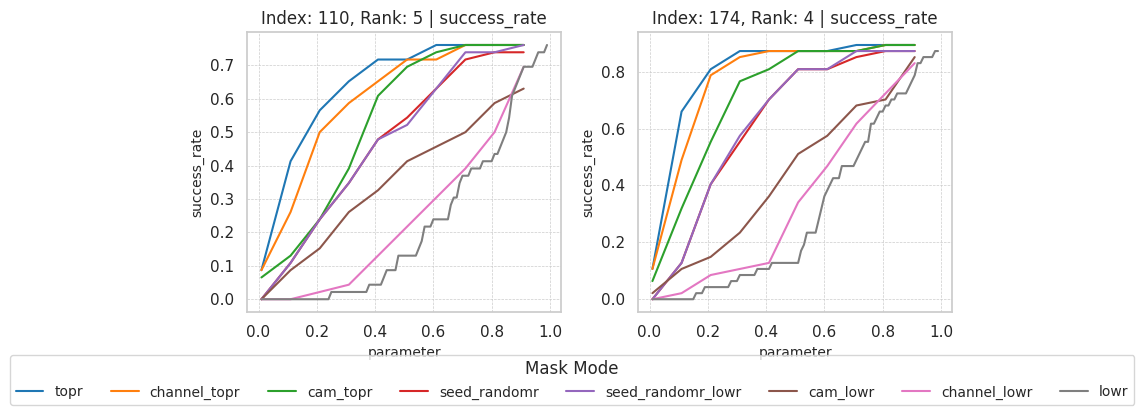

In [29]:
plot_success_rate_vs_r(data1, 0.01, 'fgsm', 'parameter', ['success_rate'], id_list = ['110', '174'],mask_mode_list = ['topr', 'channel_topr', 'cam_topr','seed_randomr', 'seed_randomr_lowr', 'cam_lowr', 'channel_lowr', 'lowr'])

# 多步法结果处理

In [ ]:
data = pd.read_excel('./data_stage3/classified_multi_attack/classified_multi_attack_1108.xlsx')

In [ ]:
data.head()

In [ ]:
def l1_norm(series):
    return series.abs().sum()

def l2_norm(series):
    return np.sqrt((series ** 2).sum())

def merge_batch_onestep(data): 
    '''将多个batch的数据合并''' 
    data['parameter'] = data['parameter'].fillna(-1)
    li = ['index','model', 'algo', 'alpha', 'mask_mode', 'step', 'parameter', 'eta']
    data_grouped = data.groupby(li).agg({
        'l1_norm': l1_norm,
        'l2_norm': l2_norm,
        'loss': 'mean',
        'pred_loss': 'mean',
        'success_rate': lambda x: round(x.mean(), 4),
        'run_time': 'sum',
    }).reset_index()
    data_grouped = data_grouped.rename(columns={'loss': 'attack_loss'})
    return data_grouped

In [ ]:
data = merge_batch_onestep(data)
data.head()

## 画出不同index，成功率和loss随step的变化


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_success_rate_vs_step(data, parameter, var, label_list, **kwargs):
    '''
    绘制不同模型下，各个标签（label）与参数（parameter）的关系图。
    每个子图表示一个模型和一个标签的关系，图例表示不同的 mask_mode。

    Args:
        data (pd.DataFrame): 数据集
        parameter (str): 攻击比例
        var: x轴参数, 例如 'step'
        label_list (list): 需要绘制的标签列表，例如 ['success_rate', 'l1_norm', 'l2_norm', 'loss', 'step']
    '''
    output_path = kwargs.get('output_path', None)
    save_name = kwargs.get('save_name', None)
    id_list = kwargs.get('id_list', ['110', '174', '230', '241', '249', '254', '369', '408', '423', '460', '492', '534', '552', '723', '725', '733', '741', '751', '848', '948'])

    mask_mode_list = kwargs.get('mask_mode_list', data['mask_mode'].unique())
    
    df_filtered = data[(data['mask_mode'].isin(mask_mode_list)) & (data['parameter'] == parameter)]
    df_filtered = df_filtered.reset_index(drop=True)
    
    ncols = kwargs.get('ncols', len(label_list))
    nrows = kwargs.get('nrows', len(id_list))

    sns.set(style="whitegrid")
    palette = sns.color_palette("tab10", n_colors=len(mask_mode_list))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4), squeeze=False)
    axes = axes.flatten()

    for i, id in enumerate(id_list):
        df_id = df_filtered[df_filtered['index'] == id]
        print(df_id)
        for j, label in enumerate(label_list):
            ax = axes[i * len(label_list) + j]
            
            # 筛选需要绘制的数据
            df_plot = df_id[[var, 'mask_mode', label]].dropna()
            sns.lineplot(
                data=df_plot, 
                x=var, 
                y=label, 
                hue='mask_mode', 
                hue_order=mask_mode_list, 
                ax=ax, 
                # marker='o', 
                palette=palette
            )
            
            # 设置子图标题和轴标签
            ax.set_title(f"Index: {id} | {label}", fontsize=12)
            ax.set_xlabel(f'{var}', fontsize=10)
            ax.set_ylabel(label, fontsize=10)
            ax.tick_params(axis='x')
            legend = ax.get_legend()
            if legend is not None:
                legend.remove()
            
    # 隐藏多余的子图
    total_subplots = nrows * ncols
    used_subplots = len(id_list) * len(label_list)
    for idx in range(used_subplots, total_subplots):
        axes[idx].axis('off')
    
    # 调整子图布局
    plt.tight_layout()

    if_legend = kwargs.get('if_legend', True)
    if if_legend:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, title='Mask Mode', loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(mask_mode_list), fontsize=11)

    plt.subplots_adjust(bottom=0.25)
    
    if output_path and save_name:
        plt.savefig(f'{output_path}/{save_name}.png', dpi=300)
    else:
        plt.show()

In [ ]:
plot_success_rate_vs_step(data, -1, 'step', ['success_rate', 'l1_norm', 'l2_norm', 'attack_loss'], id_list=[46, 74])

In [ ]:
# 只看step最大的
data1 = data[data['step'] == data['step'].max()]
data1

# 结果分析